In [1]:
import warnings
import statistics
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.stats import norm
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from lmfit import Model

In [2]:
warnings.filterwarnings('ignore')

#Parameters
V_lockin = 0.014 #Lock-in voltage (V)
k_lever_torsional = 70.7 #Torsional spring constant of cantilever (N/m)
k_lever = 1.2 #Spring constant of cantilever (N/m)
calibration_sens = 8.75 #Sensitivity from calibrating AFM (m/V)

E_sample = 36*1e9 #Young's Modulus of sample (Pa)
E_tip = 169*1e9 #Young's Modulus of cantilever tip (Pa)
v_sample = 0.2 #Poisson's ratio of sample
v_tip = 0.2 #Poisson's ratio of tip
r_tip = 10*1e-9 #Radius of the cantilever tip (m) 
G_tip = 50*1e6 #Shear Modulus (KPa)

In [3]:
def calcEStar():
    term1 = (1-v_tip**2)/E_tip
    term2 = (1-v_sample**2)/E_sample
    
    return (term1 + term2)**-1

E_star = calcEStar()

def fitting_eqn(f, g_star, f_adh):
    a = 8*g_star*(3*r_tip*(f + f_adh)/(4*E_star))**(1/3)
    return a

def loadFile(doc):
    #Load experimental data
    file = open(doc, 'r')
    linesArray = file.readlines()
    lineNum = 0
    
    #Remove heading from data
    for i in enumerate(linesArray):
        if i[1].split()[0] == 'Time':
            lineNum = i[0] + 1
            
    #Save data without header
    data = np.genfromtxt(doc,skip_header = lineNum)
    return data

In [4]:
w = 50*1e-6
L = 225*1e-6
d = 12.5*1e-6
t = 1.5*1e-6
G = 50*1e9
num = w*G*t**3
den = 3*L*(d + t/2)**2

k_lev_torsional = num/den
print(f'Torsional Spring Constant: {k_lev_torsional}')

Torsional Spring Constant: 71.19971520113921


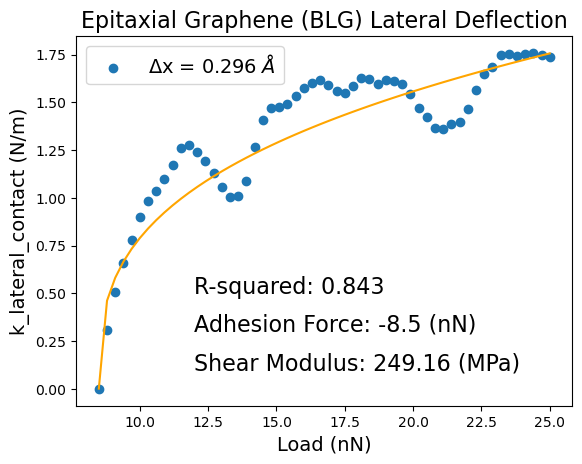

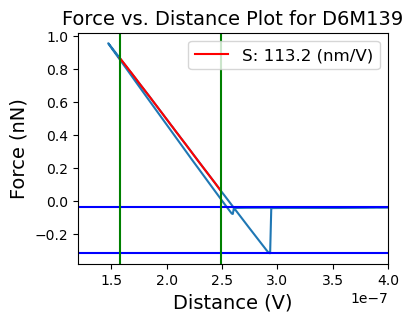

-0.31590574979782104


In [13]:
data = np.genfromtxt('LatDef_Raw_Data/20240117/LatDef Measurements/D6M139_top_line3.txt')
FDdata = loadFile('LatDef_Raw_Data/20240110/FDcurve.txt')

force = FDdata[:,2]
distance = FDdata[:,1]

zeroIndexes = np.where(np.gradient(force) == 0)
temp = 0

for i in zeroIndexes:
    temp = temp + force[i]

zeroForce = np.average(temp)
minForce = min(force)

#Perform linear regression on FD curve to get sensitivity
start = 510
end = 600

xArr = distance[start:end]
yArr = force[start:end]

sensFD = abs(linregress(xArr,yArr)[0]) #sensitivity from FD curve (V/nm)
sensFD = 1e9* 1/sensFD #sensitivity (nm/V)

f_adh = (zeroForce - minForce) * sensFD * k_lever

loads = data[:,-1]
latDef = data[:,4]

loads = loads[45:]
latDef = latDef[45:]

amplitude = 0.014
ratio = 4.14

fL = 2 * (d/L) * k_lev_torsional * sensFD * latDef * 1e-6 * 1e-9
dX = 1e-9 * calibration_sens*amplitude/ratio

fL = fL - min(fL)

k_total = fL/dX
k_cont = (1/k_total - 1/k_lev_torsional)**-1

guess = [100,100]
parameters, covariance = curve_fit(fitting_eqn, loads, k_cont, p0 = guess, maxfev = 50000)
G_star, F_adh = parameters

G_int = (2 - v_sample)/((1/G_star) - 2*v_tip/G_tip)
G_int = G_int

fit_data = fitting_eqn(np.array(loads), G_star,F_adh)

#get r-squared
r2 = r2_score(k_cont,np.real(fit_data))

plt.figure(1)
plt.scatter(loads,k_cont, label = f'$\Delta$x = {np.round(dX*1e10,3)} $\AA$')
plt.ylabel('k_lateral_contact (N/m)', fontsize = 14)
plt.xlabel('Load (nN)', fontsize = 14)
#plt.ylim(-0.3,6.3)
plt.title(f'Epitaxial Graphene (BLG) Lateral Deflection', fontsize = 16)
#plt.title(f'D6M139 (SLG) Lateral Deflection ($\phi$ = 50$\degree$)')


plt.plot(loads,np.real(fit_data) , c = 'orange')

plt.text(12,.3,f'Adhesion Force: {round(F_adh,2)} (nN)', fontsize = 16)
plt.text(12,.1,f'Shear Modulus: {round(G_int/1e3,2)} (MPa)', fontsize = 16)
plt.text(12,.5,f'R-squared: {round(r2,3)}', fontsize = 16)
plt.legend(loc = 'upper left', fontsize = 14)
plt.show()

plt.figure(2, figsize = (4,3))
plt.plot(distance, force)
plt.plot(distance[start:end],force[start:end], color = 'r', label = f'S: {round(sensFD,1)} (nm/V)')
plt.axhline(zeroForce, color = 'b')
plt.axhline(minForce, color = 'b')
plt.axvline(distance[start], color = 'g')
plt.axvline(distance[end], color = 'g')
plt.title(f'Force vs. Distance Plot for D6M139', fontsize = 14)
plt.xlabel(f'Distance (V)', fontsize = 14)
plt.ylabel(f'Force (nN)', fontsize = 14)
plt.legend(loc = 'best', fontsize = 12)
plt.xlim([1.2e-7,4e-7])
plt.show()

print(min(force))

#print(G_int,F_adh)

In [55]:
def MoNS(loadSet,latDefSet,buffer):
    sensFD = 113.5 #nm/V

    loads = loadSet
    latDef = latDefSet

    loads = loads[buffer:]
    latDef = latDef[buffer:]

    amplitude = 0.014
    ratio = 4.14

    fL = 2 * (d/L) * k_lev_torsional * sensFD * latDef * 1e-6 * 1e-9
    dX = 1e-9 * calibration_sens*amplitude/ratio

    fL = fL - min(fL)

    k_total = fL/dX
    k_cont = (1/k_total - 1/k_lev_torsional)**-1

    guess = [100,100]
    parameters, covariance = curve_fit(fitting_eqn, loads, k_cont, p0 = guess, maxfev = 50000)
    G_star, F_adh = parameters

    G_int = (2 - v_sample)/((1/G_star) - 2*v_tip/G_tip)
    G_int = G_int

    fit_data = fitting_eqn(np.array(loads), G_star,F_adh)
    
    r2 = r2_score(k_cont,np.real(fit_data))
    
    return G_int, fit_data, r2

def multiMoNS(filename, buffer):
    data = np.genfromtxt(filename)

    trials = len(data[1,:]) - 1
    points = len(data[:,-1])

    k_contacts = np.zeros((trials,points - buffer))
    g_ints = np.zeros(trials)
    r2_array = np.zeros(trials)
    sumArray = np.zeros(points - buffer)
    loads = data[:,-1]
    bufferLoads = loads[buffer:]

    for i in range(trials):
        g_ints[i],k_contacts[i],r2_array[i] = MoNS(loads,data[:,i],buffer)

        sumArray = sumArray + k_contacts[i]
        
    avgArray = sumArray/trials
    g_ints = g_ints/10**3
    
    return g_ints,k_contacts,r2_array,avgArray,bufferLoads

(-8.0, 175.0)

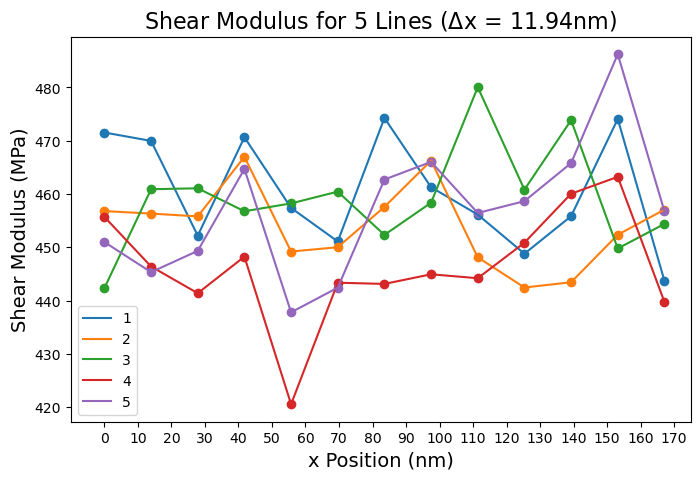

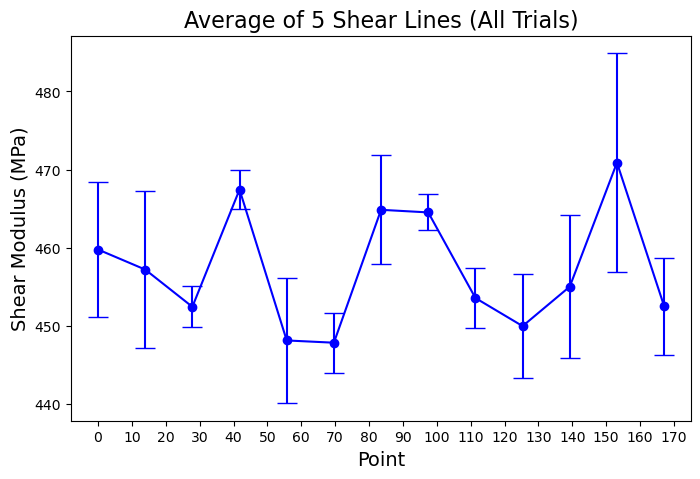

In [125]:
plt.figure(1, figsize = (8,5))

xpos = np.linspace(0, 167.1, len(shear_moduli) - 1)

plt.title(f'Shear Modulus for 5 Lines ($\Delta$x = 11.94nm)', fontsize = 16)
plt.plot(xpos,shear_moduli[1:], label = '1')
plt.scatter(xpos, shear_moduli[1:])

plt.plot(xpos,shear_moduli2[1:], label = '2')
plt.scatter(xpos, shear_moduli2[1:])

plt.plot(xpos,shear_moduli3[1:], label = '3')
plt.scatter(xpos, shear_moduli3[1:])

plt.plot(xpos,shear_moduli4[1:], label = '4')
plt.scatter(xpos, shear_moduli4[1:])

plt.plot(xpos,shear_moduli5[1:], label = '5')
plt.scatter(xpos, shear_moduli5[1:])

plt.xlabel('x Position (nm)', fontsize = 14)
plt.ylabel('Shear Modulus (MPa)', fontsize = 14)
plt.xticks(range(0,180,10))
plt.xlim([-10,175])
#plt.ylim([650,850])

plt.legend(loc = 'best')


avg = (shear_moduli + shear_moduli2 + shear_moduli5)/3

stdev = np.zeros(len(shear_moduli))

for i in range(len(shear_moduli)):
    temp = np.std([shear_moduli[i],shear_moduli2[i],shear_moduli5[i]])
    stdev[i] = temp
    

plt.figure(2, figsize = (8,5))
plt.errorbar(xpos,avg[1:], yerr = stdev[1:], capsize = 7, c = 'b')
plt.scatter(xpos,avg[1:], c = 'b')
plt.title('Average of 5 Shear Lines (All Trials)', fontsize = 16)
plt.xlabel('Point', fontsize = 14)
plt.ylabel('Shear Modulus (MPa)', fontsize = 14)
plt.xticks(range(0,180,10))
plt.xlim([-8,175])

Text(1000, 0.7, '$\\frac{Def(50 Hz)}{Def(2123 Hz)} = $[4.38]')

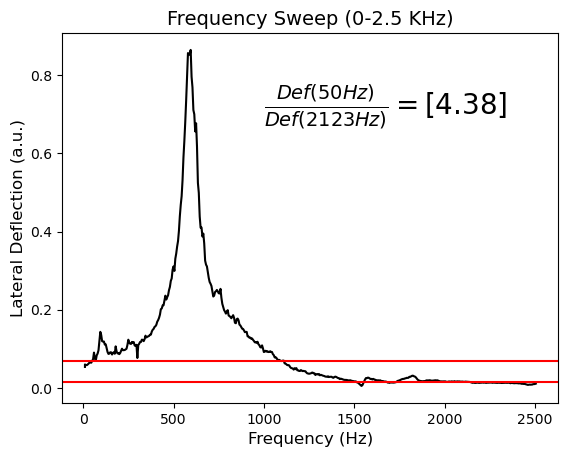

In [8]:
#frequency sweep plotting
freqSweepData = np.genfromtxt('LatDef_Raw_Data/20231003/FrequencySweep_0.004.txt')
frequencies = freqSweepData[:,0]
latDefs = freqSweepData[:,1]
stds = freqSweepData[:,2]

ratio = np.round(latDefs[np.where(frequencies == 50)]/latDefs[np.where(frequencies == 2125)], 2)

plt.figure(4)
plt.plot(frequencies,latDefs, c = 'black')
plt.axhline(latDefs[np.where(frequencies == 50)], c = 'r')
plt.axhline(latDefs[np.where(frequencies == 2125)], c = 'r')
plt.xlabel('Frequency (Hz)', fontsize = 12)
plt.ylabel('Lateral Deflection (a.u.)', fontsize = 12)
plt.title('Frequency Sweep (0-2.5 KHz)', fontsize = 14)
plt.text(1000,0.7, r'$\frac{Def(50 Hz)}{Def(2123 Hz)} = $' + f'{ratio}', fontsize = 20)